In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras import optimizers
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.ticker as ticker
from keras import backend as K
import csv
import matplotlib.pyplot as plt
import numpy as np
import time 
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import os
import pandas as pd

Using TensorFlow backend.


In [2]:
def spread(x):
    return max(x)-min(x)

In [3]:
data_dir = "../QAR/output/bond/"

In [4]:
data = pd.read_csv(data_dir + 'bond_disbond_qper_for_cnn.csv')

In [5]:
folds = data['fold']
labels = data['class']
data = data[data.columns[2:]]
nr = 45
nc = 128

In [6]:
x = np.array(data)
x = x.reshape( [-1, nr, nc, 1])
x.shape

(708, 45, 128, 1)

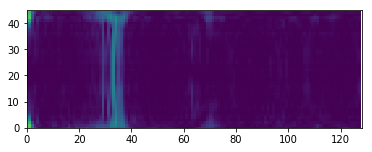

In [8]:
plt.imshow(x[0].reshape([nr,nc]))
plt.axis([0,nc,0,nr])
plt.show()

In [9]:
ns = x.shape[0]
y = np.ones([ns,2])
for i in range(ns):
    if labels[i] == 1:
        y[i] = [1,0]
    else:
        y[i] = [0,1]

In [191]:
f1 = 16
f2 = 8
k1 = 5
k2 = 5
h1 = 512
h2 = 512
h3 = 512
lr = 1e-4
epochs = 100
batch_size = 50
padding = 'same'
nfolds = max(folds)
accuracy_train = np.ones(nfolds)
accuracy_test = np.ones(nfolds)
for i in range(nfolds):
    test_sel = (folds == i+1)
    train_sel = ~(folds == i+1)
    x_train = x[train_sel,]
    y_train = y[train_sel,]
    x_test = x[test_sel,]
    y_test = y[test_sel,]
    np.random.seed(1000)
    idx = np.random.permutation(x_train.shape[0]) ## shuffle training data
    x_train = x_train[idx,]
    y_train = y_train[idx,]
    print('Fold',i+1)
    K.clear_session()
    tf.random.set_seed(1000)
    my_init = tf.keras.initializers.glorot_normal(seed=1000)
    inp = Input(shape=(nr,nc,1),dtype = 'float32')
    conv1 = layers.Conv2D(f1,(k1,k1), activation = 'relu',input_shape = (nr,nc,1),padding = padding)(inp)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    conv2 = layers.Conv2D(f2,(k2,k2), activation = 'relu',padding = padding)(pool1)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    flat = layers.Flatten()(pool2)
    ##flat = layers.Dropout(0.5)(flat)
    fc1 = layers.Dense(h1,activation = 'relu',kernel_initializer=my_init)(flat)
    ##fc1 = layers.Dropout(0.2)(fc1)
    fc2 = layers.Dense(h2,activation = 'relu',kernel_initializer=my_init)(fc1)
    ##fc2 = layers.Dropout(0.2)(fc2)
    out = layers.Dense(2,activation = 'sigmoid',kernel_initializer=my_init)(fc2)
    model = Model(inp,out)
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(lr = lr), metrics = ['acc'])
    filepath = 'bond_disbond'+str(i)+'b.h5'
    if os.path.exists(filepath): os.remove(filepath)
    callbacks_list = [tf.keras.callbacks.ModelCheckpoint(filepath=filepath,monitor='val_loss',save_best_only=True), 
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)]
    history = model.fit(x_train,y_train,validation_split=0.2,epochs=epochs,
        batch_size=batch_size,callbacks=callbacks_list,verbose=0)
    ytrain_pred = model.predict([x_train])
    ytest_pred = model.predict([x_test])
    ytr_pred0 = ytrain_pred[:,0] > ytrain_pred[:,1]
    yte_pred0 = ytest_pred[:,0] > ytest_pred[:,1]
    accuracy_train[i] = 100*(1.0 - np.mean(ytr_pred0 == y_train[:,1]))
    accuracy_test[i] = 100*(1.0 - np.mean(yte_pred0 == y_test[:,1]))
model.summary()

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 45, 128, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 45, 128, 16)       416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 64, 8)         3208      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 32, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2816)              0         
_________________________________________________________________
dense (Dense)             

In [192]:
print('mean accuracy in train =', np.round(np.mean(accuracy_train),2),' spread =',np.round(spread(accuracy_train),2))
print('mean accuracy in test  =', np.round(np.mean(accuracy_test),2),' spread =',np.round(spread(accuracy_test),2))
print('accuracy_train =',np.round(accuracy_train,2))
print('accuracy_test  =',np.round(accuracy_test,2))

mean accuracy in train = 99.29  spread = 1.06
mean accuracy in test  = 98.45  spread = 2.11
accuracy_train = [99.82 98.77 98.94 99.47 99.47]
accuracy_test  = [98.6  98.58 99.29 97.18 98.58]


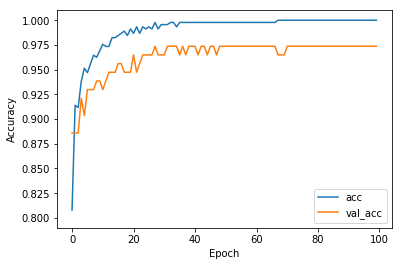

In [193]:
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label = 'val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.79, 1.01])
plt.legend(loc='lower right')

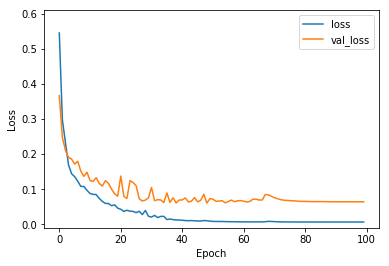

In [194]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([-0.01, 0.61])
plt.legend(loc='upper right')